<a href="https://colab.research.google.com/github/PGestrich/AML-Time-Series-Forecasting/blob/main/AML_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML Project - Time Series Forecasting

Julian Nürk, 

Prisca Gestrich

## Data Stuff

### 1. Utility / Loading Data

In [1]:
#general
import numpy as np
import pandas as pd
!pip install -q kaggle


from google.colab import files

In [2]:
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'store-sales-time-series-forecasting'
! mkdir data
! unzip store-sales-time-series-forecasting.zip -d data

Saving kaggle.json to kaggle.json
 94% 20.0M/21.4M [00:00<00:00, 95.0MB/s]
100% 21.4M/21.4M [00:00<00:00, 99.7MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: data/holidays_events.csv  
  inflating: data/oil.csv            
  inflating: data/sample_submission.csv  
  inflating: data/stores.csv         
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/transactions.csv   


In [302]:
oil = pd.read_csv('/content/data/oil.csv')
holidays = pd.read_csv('/content/data/holidays_events.csv')
stores = pd.read_csv('/content/data/stores.csv')
train = pd.read_csv('/content/data/train.csv')
transactions = pd.read_csv('/content/data/transactions.csv')
test = pd.read_csv('/content/data/test.csv')



## Process Data

holiday handling:

0: work day

1 - weekend / bridge day

2 - holiday

type additional: ??? 

transferred holidays are considered normal days

only first holiday in holidays is considered




In [303]:
#change dtype of date column to datetime
oil['date'] = oil['date'].apply(pd.to_datetime)
holidays['date'] = holidays['date'].apply(pd.to_datetime)
train['date'] = train['date'].apply(pd.to_datetime)
transactions['date'] = transactions['date'].apply(pd.to_datetime)
test['date'] = test['date'].apply(pd.to_datetime)

In [304]:
#expand oil to include all dates + interpolate missing data
oil = oil.set_index('date').asfreq('D').reset_index()
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate('linear').ffill().bfill()
train = train.merge(oil)
train = train.rename(columns={"dcoilwtico": "oilprice"})


#change family names to numeric values
fam = np.unique(train['family'])
fam_lookup = pd.DataFrame(data = {'family': fam, 'family_id': range(len(fam))})
train  = train.merge(fam_lookup)


#split up date into multiple informations
train['day'] = train['date'].apply(lambda time: time.day)
train['month'] = train['date'].apply(lambda time: time.month)
train['weekday'] = train['date'].apply(lambda time: time.dayofweek)
train['year'] = train['date'].apply(lambda time: time.year)

#remove noise - half a year after earthquake
to_drop = train.loc[train['date'].between('2016-04-16', '2016-10-16')]
train = train.drop(to_drop.index)

prob. faster: do holiday lookup table with clusters instead of store numbers

In [305]:
#holiday handling
def isholiday(row):
  #data
  date = row['date']
  event = holidays.loc[holidays['date'] == date][0:1]
  id = row['store_nbr']
  city = stores.loc[stores['store_nbr'] == id]['city'].values
  state = stores.loc[stores['store_nbr'] == id]['state'].values
  
  
  #check if events apply:
  if len(event) > 0:
    national = event['locale'].values == 'National'
    regional = event['locale'].values == 'Regional' and event['locale_name'].values == state
    local = event['locale'].values == 'Local' and event['locale_name'].values == city
    
    if national[0] or regional[0] or local[0]:
      if event['type'].values == 'Holiday' and  event['transferred'].values == False:
        return 2
      elif event['type'].values == 'Transfer':
        return 2
      elif event['type'].values == 'Bridge':
        return 1
      elif event['type'].values == 'Work Day':
        return 0

  #otherwise: check if weekend
  if row['weekday']< 5:
    return 0
  else: 
    return 1


#lookup table  (adds dates to stores table and gets holiday type)
date1, date2 = train['date'].min(), train['date'].max()
holiday_lookup = stores[['store_nbr', 'type']].copy()
holiday_lookup.loc[:,'holiday'] = 0

holiday_lookup = pd.merge(holiday_lookup, pd.DataFrame({'date': pd.date_range(date1, date2, freq = 'd')}), how = "cross")
holiday_lookup['weekday'] = holiday_lookup['date'].apply(lambda time: time.dayofweek)
holiday_lookup.loc[:, 'holiday'] = holiday_lookup.apply(lambda row: isholiday(row), axis = 1)
holiday_lookup = holiday_lookup.drop('weekday', axis = 1)


#join with train
train = train.merge(holiday_lookup)

In [306]:
#create shortened data for test purposes
date1 = '2013-01-01'
date2 = '2013-01-03'

oil_short = oil.loc[oil['date'].between(date1, date2)]
holidays_short = holidays.loc[holidays['date'].between(date1, date2)]
train_short = train.loc[train['date'].between(date1, date2)].copy()
transactions_short = transactions.loc[transactions['date'].between(date1, date2)]

train_short

,id,date,store_nbr,family,sales,onpromotion,oilprice,family_id,day,month,weekday,year,type,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,D,2
1,1,2013-01-01,1,BABY CARE,0.000,0,93.14,1,1,1,1,2013,D,2
2,2,2013-01-01,1,BEAUTY,0.000,0,93.14,2,1,1,1,2013,D,2
3,3,2013-01-01,1,BEVERAGES,0.000,0,93.14,3,1,1,1,2013,D,2
4,4,2013-01-01,1,BOOKS,0.000,0,93.14,4,1,1,1,2013,D,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,5341,2013-01-03,9,POULTRY,509.496,0,92.97,28,3,1,3,2013,B,0
5342,5342,2013-01-03,9,PREPARED FOODS,66.000,0,92.97,29,3,1,3,2013,B,0
5343,5343,2013-01-03,9,PRODUCE,0.000,0,92.97,30,3,1,3,2013,B,0
5344,5344,2013-01-03,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,92.97,31,3,1,3,2013,B,0


In [307]:
test = pd.read_csv('/content/data/test.csv')
test['date'] = test['date'].apply(pd.to_datetime)

# preprocess test data
test = test.merge(oil)
test = test.rename(columns={"dcoilwtico": "oilprice"})



#change family names to numeric values
test  = test.merge(fam_lookup)


#split up date into multiple informations
test['day'] = test['date'].apply(lambda time: time.day)
test['month'] = test['date'].apply(lambda time: time.month)
test['weekday'] = test['date'].apply(lambda time: time.dayofweek)
test['year'] = test['date'].apply(lambda time: time.year)

In [308]:
#test holiday handling

#holiday handling
def isholiday(row):
  #data
  date = row['date']
  event = holidays.loc[holidays['date'] == date][0:1]
  id = row['store_nbr']
  city = stores.loc[stores['store_nbr'] == id]['city'].values
  state = stores.loc[stores['store_nbr'] == id]['state'].values
  
  
  #check if events apply:
  if len(event) > 0:
    national = event['locale'].values == 'National'
    regional = event['locale'].values == 'Regional' and event['locale_name'].values == state
    local = event['locale'].values == 'Local' and event['locale_name'].values == city
    
    if national[0] or regional[0] or local[0]:
      if event['type'].values == 'Holiday' and  event['transferred'].values == False:
        return 2
      elif event['type'].values == 'Transfer':
        return 2
      elif event['type'].values == 'Bridge':
        return 1
      elif event['type'].values == 'Work Day':
        return 0

  #otherwise: check if weekend
  if row['weekday']< 5:
    return 0
  else: 
    return 1


#lookup table  (adds dates to stores table and gets holiday type)
date1, date2 = test['date'].min(), test['date'].max()
holiday_lookup = stores[['store_nbr', 'type']].copy()
holiday_lookup.loc[:,'holiday'] = 0

holiday_lookup = pd.merge(holiday_lookup, pd.DataFrame({'date': pd.date_range(date1, date2, freq = 'd')}), how = "cross")
holiday_lookup['weekday'] = holiday_lookup['date'].apply(lambda time: time.dayofweek)
holiday_lookup.loc[:, 'holiday'] = holiday_lookup.apply(lambda row: isholiday(row), axis = 1)
holiday_lookup = holiday_lookup.drop('weekday', axis = 1)


#join with train
test = test.merge(holiday_lookup)

## Test with Shortened Train set

In [ ]:
#create testset only considering automotives at store 1
'''train_auto = train.copy()
print(train_auto.shape[0])
train_auto = train_auto.loc[train_auto['family'] == "AUTOMOTIVE"]
train_auto = train_auto.loc[train_auto['store_nbr'] == 1]
print(train_auto.shape[0])

train_auto['date'] = train_auto['date'].apply(pd.to_datetime)
train_auto['weekday'] = train_auto['date'].apply(lambda time: time.dayofweek)
train_auto['day'] = train_auto['date'].apply(lambda time: time.day)



X_train = train_auto[['id', 'day', 'weekday', 'onpromotion']]
plot_dates = train_auto[['date']]
Y_train = train_auto[['sales']]


train_auto = test.copy()
print(train_auto.shape[0])
train_auto = train_auto.loc[train_auto['family'] == "AUTOMOTIVE"]
train_auto = train_auto.loc[train_auto['store_nbr'] == 1]
print(train_auto.shape[0])

train_auto['date'] = train_auto['date'].apply(pd.to_datetime)
train_auto['weekday'] = train_auto['date'].apply(lambda time: time.dayofweek)
train_auto['day'] = train_auto['date'].apply(lambda time: time.day)

X_test = train_auto[['id', 'day', 'weekday', 'onpromotion']]
'''

3000888
1684
28512
16


In [265]:
#create test data for one family

cluster = stores[['store_nbr', 'cluster']].groupby('cluster').count().idxmax().values[0]
stores_in_cluster = stores.loc[stores['cluster'] == cluster]['store_nbr'].values

train_simple = train.loc[train['store_nbr'].isin(stores_in_cluster)].copy()
train_simple = train_simple.loc[train_simple['family_id'] == 32]

sales_simple = train_simple[['sales', 'date']].copy()
#train_simple = train_simple[['date', 'store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month']]
train_simple = train_simple[['date', 'store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month']]

X_train = train_simple.loc[train_simple['date'].between('2013-01-01', '2017-07-31')]
X_test = train_simple.loc[train_simple['date'].between('2017-08-01', '2017-08-15')]
Y_train = sales_simple.loc[sales_simple['date'].between('2013-01-01', '2017-07-31')]
Y_test = sales_simple.loc[sales_simple['date'].between('2017-08-01', '2017-08-15')]

X_train = X_train.drop('date', axis=1)
Y_train = Y_train.drop('date', axis=1)
X_test = X_test.drop('date', axis=1)
Y_test = Y_test.drop('date', axis=1)

print(X_train.shape, '\n', Y_train.shape)

(10395, 9) 
 (10395, 1)


## Regression

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [271]:
#test simple data
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train.values.ravel())

predict = regr.predict(X_test)

print(mean_squared_error(predict, Y_test.values))

6.854681228245477


## Plots

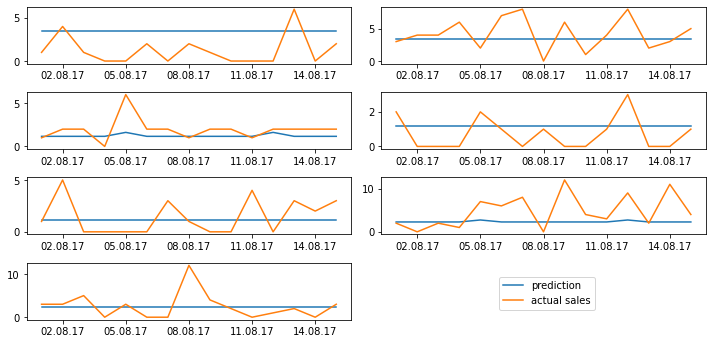

In [267]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

#fig, ax = plt.subplots(figsize=(8, 5))

x =  pd.date_range('2017-08-01', '2017-08-15', freq = 'd')
date_form = DateFormatter("%d.%m.%y")
n = len(stores_in_cluster)

#bring values in useful shape
y_val = Y_test.values
y_val = y_val.reshape(-1, n).transpose()
p_val = predict.reshape(-1, n).transpose()


#create subplots
if n % 2 == 0:
      f, axs = plt.subplots(n/2, 2, figsize=(10,5))
else:
    f, axs = plt.subplots(int((n+1)/2), 2,  figsize=(10,5),)

#add values
for i in range(n):
    y1 = p_val[i]
    y2 = y_val[i]

    if i % 2 == 0:
      nb = int(i/2)
    else:
      nb = int((i)/2)
    
    axs[nb, i%2].plot(x, y1)
    axs[nb, i%2].plot(x, y2)
    axs[nb, i%2].xaxis.set_major_formatter(date_form)
    axs[nb, i%2].xaxis.set_major_locator(mdates.DayLocator(interval=3))
        
if n % 2 != 0:
    f.delaxes(axs[int((i)/2), 1])

f.tight_layout() 
f.subplots_adjust(bottom=0.1)   ##  Need to play with this number.
f.legend(labels = ['prediction', 'actual sales'], loc=(.7,.1))

#f.suptitle('Results Random Forest Regression')


f.show()

Text(0.5, 1.0, 'total sales')

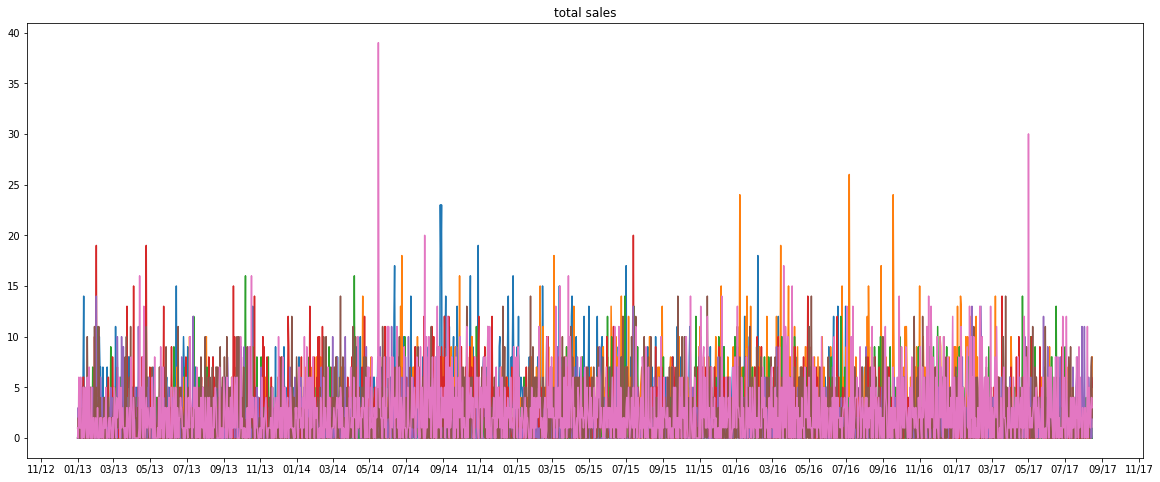

In [129]:
fig, ax = plt.subplots(figsize=(20, 8))
#get dates
date1, date2 = sales_simple['date'].min(), sales_simple['date'].max()
plot_dates =  pd.date_range(date1, date2, freq = 'd')

leap = []
for each in plot_dates:
    if each.month==12 and each.day ==25:
        leap.append(each)
plot_dates = plot_dates.drop(leap)

s = sales_simple['sales'].values.reshape(n, -1).transpose()
plt.plot(plot_dates, s, label = stores_in_cluster)
date_form = DateFormatter("%m/%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.title('total sales')

In [128]:
plot_dates.difference(sales_simple['date'])


DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

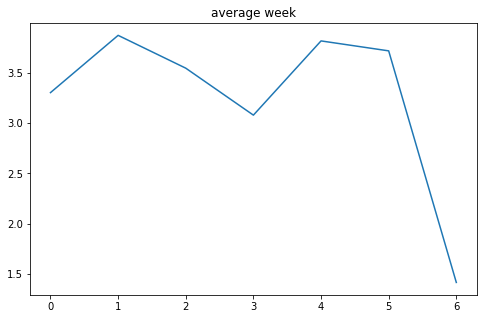

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

days = np.zeros(7)
counter  = np.zeros(7)

dates = plot_dates.copy()
dates['weekday'] = dates['date'].apply(lambda time: time.dayofweek)

wd = dates['weekday'].values.flatten()

sales = Y_train.values.flatten()
for i in range(len(plot_dates)):
  weekday = wd[i]
  days[weekday] += sales[i]
  counter[weekday] += 1

days = days/counter
fig, ax = plt.subplots(figsize=(8, 5))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(days, label = "prediction")
plt.title('average week')
plt.show()

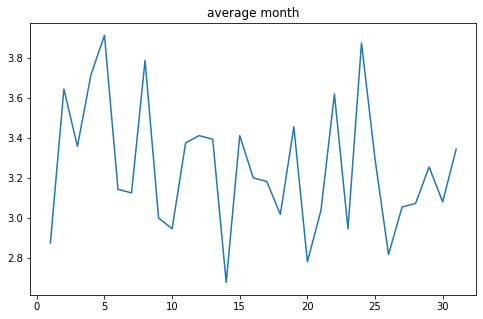

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

days = np.zeros(31)
counter  = np.zeros(31)

dates = plot_dates.copy()
dates['day'] = dates['date'].apply(lambda time: time.day)

wd = dates['day'].values.flatten()

sales = Y_train.values.flatten()
for i in range(len(plot_dates)):
  weekday = wd[i] - 1
  days[weekday] += sales[i]
  counter[weekday] += 1

days = days/counter
fig, ax = plt.subplots(figsize=(8, 5))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(range(1, 32), days, label = "prediction")
plt.title('average month')
plt.show()

## Full Dataset

In [317]:
models = []


family_nbr = train['family_id'].max()

for fam in range(family_nbr):
  train_fam = train.loc[train['family_id']== fam]
  X_train = train_fam[['store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month']].values
  Y_train = train_fam['sales']

  regr = RandomForestRegressor(max_depth=2, random_state=0)
  regr.fit(X_train, Y_train.values.ravel())

  models.append(regr)



In [318]:
def pred(row):
  i = row['family_id']
  X = row[['store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month']].values.reshape(1,-1)
  return models[i-1].predict(X)

test[:,'prediction']  = test.apply(lambda row: pred(row), axis = 1)


TypeError: ignored

In [ ]:
test

In [ ]:
path = '/content/'
test[['id', 'prediction']].to_csv(path, header = 'id,sales', index = False)